# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнила:**

Нечаева Анна Анатольевна, 312298

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После ознакомления, выполнить практическое задание в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'drive/MyDrive/AAI/lab_3_data/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd AAI/lab_3_data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/AAI/lab_3_data/flowers


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/content/drive/My Drive/AAI/lab_3_data/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

('/content/drive/My Drive/AAI/lab_3_data/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои
***
**Conv2d**

**stride(int or tuple, optional)** $-$ размер шага свертки

**padding(int or tuple, optional)** $-$ количество слоев, чтобы добавить 0 к каждой стороне ввода (вокруг нашей матрицы делаем еще n слоев из нулей)

**MaxPool2d**
снижает размерность поступивших на него данных. если некая область содержит ярко выраженные свойства, то мы можем отказаться от поиска других свойств в этой области.

**Flatten** преобразует формат изображений из 2d-массивa в 1d-массив

**kernel_size**: Целое число или кортеж/перечень из 3-х целых чисел, задающих глубину, высоту и ширину окна 3D свертки. Может быть одним целым числом, задающим одно и то же значение для всех пространственных измерений.

***
nn.Conv2d — это класс в библиотеке PyTorch, который используется для создания двумерных свёрточных слоёв. Он применяется в основном в задачах обработки изображений, таких как классификация, сегментация и детекция объектов. Вот основные параметры этого класса и их назначение:

1. in_channels (int):

   • Количество входных каналов. Например, для цветного изображения RGB это будет 3, а для черно-белого — 1.

2. out_channels (int):

   • Количество выходных каналов (фильтров), которые будут применены к входным данным. Это определяет количество карт активации на выходе.

3. kernel_size (int or tuple):

   • Размер ядра свёртки. Может быть задан как одно целое число (например, 3 для 3x3) или как кортеж (например, (3, 5) для 3x5).

4. stride (int or tuple, optional):

   • Шаг свёртки, который определяет, насколько сдвигается фильтр при применении к входным данным. По умолчанию равен 1.

5. padding (int or tuple, optional):

   • Количество пикселей, добавляемых к каждому краю входного изображения. Это может помочь сохранить размер выходного изображения. Например, при использовании padding=1 с ядром 3x3 размер выходного изображения будет таким же, как и входного.

6. dilation (int or tuple, optional):

   • Расстояние между элементами ядра свёртки. Это позволяет увеличивать размер ядра без увеличения количества параметров.

7. groups (int, optional):

   • Определяет количество групп свёртки. Если groups равно 1 (по умолчанию), то обычная свёртка применяется ко всем каналам. Если больше 1, то используется глубинная свёртка.

8. bias (bool, optional):

   • Указывает, нужно ли добавлять смещение к выходу. По умолчанию равно True.

9. padding_mode (string, optional):

   • Определяет метод дополнения границ входного изображения. Возможные значения: 'zeros' (по умолчанию) и 'reflect' или 'replicate'.
   ***

   1. Свёрточные слои и активация:

   • Сначала вы создаете два свёрточных слоя с 32 и 64 выходными каналами, каждый из которых последовательно следует за функцией активации ReLU.

   • Затем вы применяете слой подвыборки (MaxPooling), который уменьшает размерность изображения вдвое.

2. Повторение структуры:

   • Далее идет еще два свёрточных слоя с 128 выходными каналами, снова с ReLU и MaxPooling.

   • После этого добавляются два свёрточных слоя с 256 выходными каналами, также с ReLU и MaxPooling.

3. Плоское представление:

   • После свёрточных слоёв вы используете nn.Flatten(), чтобы преобразовать многомерный тензор в одномерный для подачи на полносвязные слои.

4. Полносвязные слои:

   • Вы добавляете три полносвязных слоя (Linear), где последний слой имеет 5 выходов, что может соответствовать 5 классам для задачи классификации.

   ***

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

In [ ]:
!nvidia-smi

Thu Dec 19 00:00:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              28W /  70W |    909MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Запускаем обучение на 10 эпох

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [00:37<00:00,  2.79it/s]


[training] Epoch: 0.00. Loss: 1.41. Accuracy: 36.63% 


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


[validation] Epoch: 0.00. Loss: 1.80. Accuracy: 32.80% 


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[training] Epoch: 1.00. Loss: 1.36. Accuracy: 38.82% 


100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


[validation] Epoch: 1.00. Loss: 1.53. Accuracy: 40.55% 


100%|██████████| 104/104 [00:33<00:00,  3.08it/s]


[training] Epoch: 2.00. Loss: 1.30. Accuracy: 42.46% 


100%|██████████| 32/32 [00:06<00:00,  5.25it/s]


[validation] Epoch: 2.00. Loss: 1.39. Accuracy: 44.50% 


100%|██████████| 104/104 [00:34<00:00,  3.05it/s]


[training] Epoch: 3.00. Loss: 1.23. Accuracy: 46.31% 


100%|██████████| 32/32 [00:06<00:00,  5.05it/s]


[validation] Epoch: 3.00. Loss: 1.30. Accuracy: 48.03% 


100%|██████████| 104/104 [00:33<00:00,  3.11it/s]


[training] Epoch: 4.00. Loss: 1.14. Accuracy: 50.73% 


100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


[validation] Epoch: 4.00. Loss: 1.24. Accuracy: 51.34% 


100%|██████████| 104/104 [00:33<00:00,  3.11it/s]


[training] Epoch: 5.00. Loss: 1.06. Accuracy: 55.31% 


100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


[validation] Epoch: 5.00. Loss: 1.21. Accuracy: 53.63% 


100%|██████████| 104/104 [00:34<00:00,  3.02it/s]


[training] Epoch: 6.00. Loss: 0.96. Accuracy: 59.62% 


100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


[validation] Epoch: 6.00. Loss: 1.24. Accuracy: 55.16% 


100%|██████████| 104/104 [00:33<00:00,  3.07it/s]


[training] Epoch: 7.00. Loss: 0.87. Accuracy: 63.73% 


100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


[validation] Epoch: 7.00. Loss: 1.34. Accuracy: 55.99% 


100%|██████████| 104/104 [00:33<00:00,  3.12it/s]


[training] Epoch: 8.00. Loss: 0.79. Accuracy: 67.22% 


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[validation] Epoch: 8.00. Loss: 1.48. Accuracy: 56.51% 


100%|██████████| 104/104 [00:33<00:00,  3.08it/s]


[training] Epoch: 9.00. Loss: 0.73. Accuracy: 70.12% 


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]

[validation] Epoch: 9.00. Loss: 1.58. Accuracy: 56.66% 


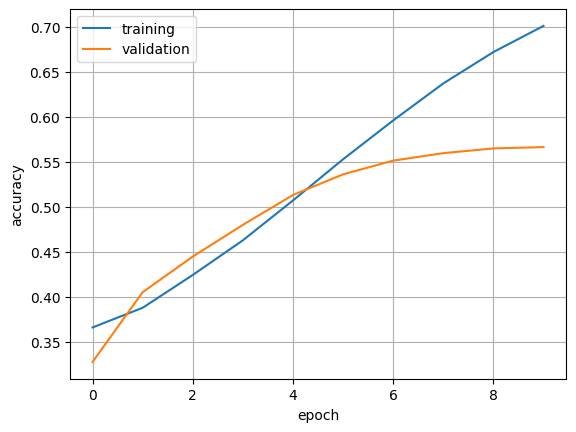

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

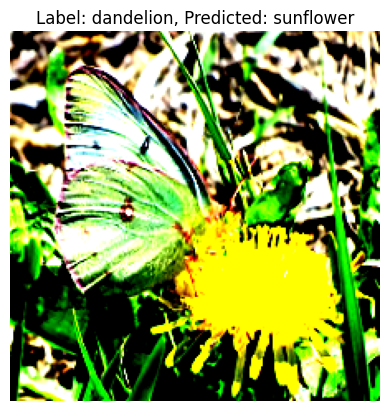

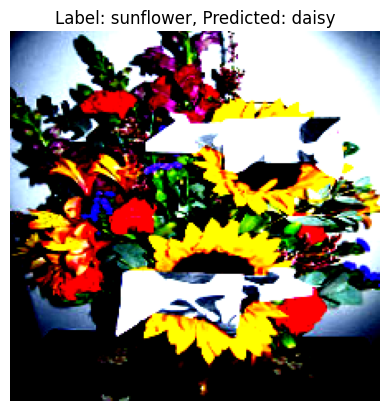

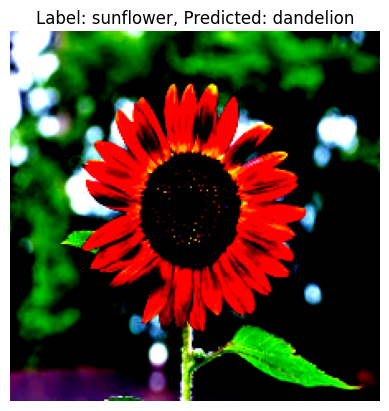

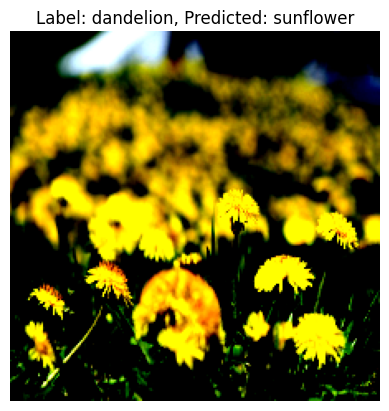

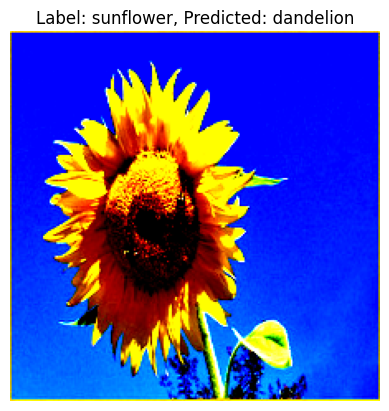

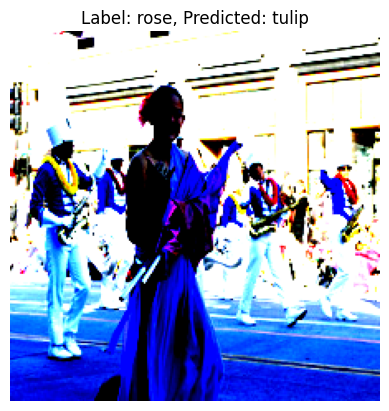

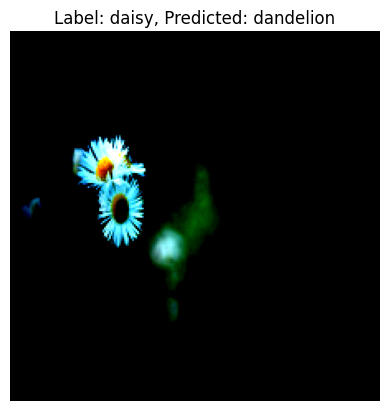

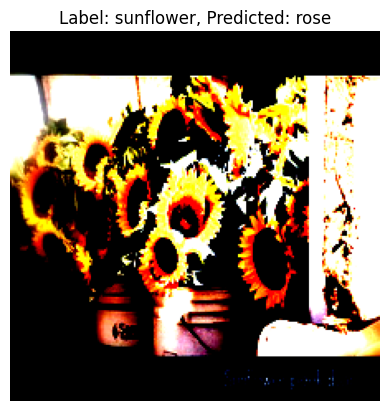

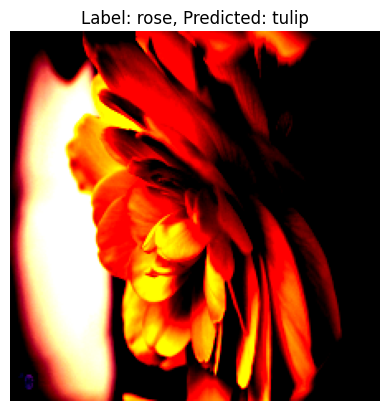

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

In [ ]:

# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!

model_pre = torchvision.models.resnet50(pretrained=True)
model_pre

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model_pre) # передайте модель в функцию для "заморозки" градиента

In [ ]:
model_pre.fc = nn.Linear(2048, 5)
# Меняем последний слой модели Зачем? Сколькой нужно выходов?

# Меняем последний слой модели, чтобы он предсказывал 5 классов, а не 1000
# Когда мы заново определяем слой, у него по умолчанию стоит аттрибут requires_grad = True
# То есть этот полносвязный слой будет обучаться

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model_pre.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [ ]:
model_pre.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model_pre.parameters()) # алгоритм оптимизации
loss_track_pre, accuracy_track_pre = trainval(model_pre, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track

100%|██████████| 104/104 [00:23<00:00,  4.40it/s]


[training] Epoch: 0.00. Loss: 0.69. Accuracy: 77.66% 


100%|██████████| 32/32 [00:06<00:00,  5.25it/s]


[validation] Epoch: 0.00. Loss: 0.43. Accuracy: 85.90% 


100%|██████████| 104/104 [00:23<00:00,  4.37it/s]


[training] Epoch: 1.00. Loss: 0.54. Accuracy: 82.02% 


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[validation] Epoch: 1.00. Loss: 0.39. Accuracy: 87.00% 


100%|██████████| 104/104 [00:23<00:00,  4.44it/s]


[training] Epoch: 2.00. Loss: 0.48. Accuracy: 83.85% 


100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


[validation] Epoch: 2.00. Loss: 0.37. Accuracy: 87.83% 


100%|██████████| 104/104 [00:25<00:00,  4.09it/s]


[training] Epoch: 3.00. Loss: 0.45. Accuracy: 84.99% 


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


[validation] Epoch: 3.00. Loss: 0.36. Accuracy: 87.97% 


100%|██████████| 104/104 [00:23<00:00,  4.49it/s]


[training] Epoch: 4.00. Loss: 0.42. Accuracy: 85.91% 


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


[validation] Epoch: 4.00. Loss: 0.35. Accuracy: 88.24% 


100%|██████████| 104/104 [00:23<00:00,  4.48it/s]


[training] Epoch: 5.00. Loss: 0.39. Accuracy: 86.70% 


100%|██████████| 32/32 [00:06<00:00,  5.05it/s]


[validation] Epoch: 5.00. Loss: 0.34. Accuracy: 88.47% 


100%|██████████| 104/104 [00:24<00:00,  4.21it/s]


[training] Epoch: 6.00. Loss: 0.37. Accuracy: 87.36% 


100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


[validation] Epoch: 6.00. Loss: 0.33. Accuracy: 88.73% 


100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


[training] Epoch: 7.00. Loss: 0.36. Accuracy: 87.75% 


100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


[validation] Epoch: 7.00. Loss: 0.33. Accuracy: 88.82% 


100%|██████████| 104/104 [00:23<00:00,  4.42it/s]


[training] Epoch: 8.00. Loss: 0.35. Accuracy: 88.20% 


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[validation] Epoch: 8.00. Loss: 0.33. Accuracy: 88.97% 


100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


[training] Epoch: 9.00. Loss: 0.34. Accuracy: 88.47% 


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]

[validation] Epoch: 9.00. Loss: 0.32. Accuracy: 89.04% 


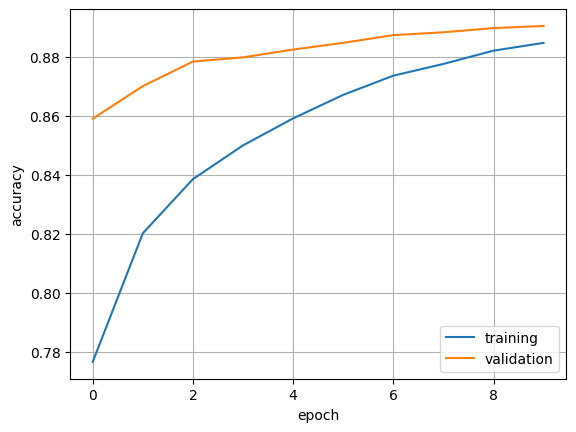

In [ ]:
plt.plot(accuracy_track_pre['training'], label='training')
plt.plot(accuracy_track_pre['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

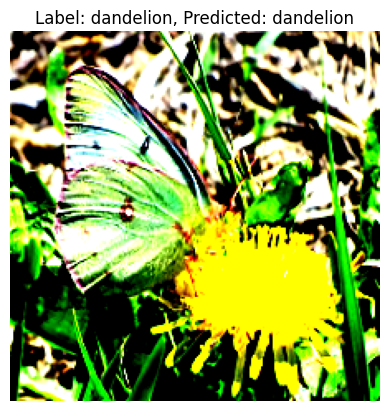

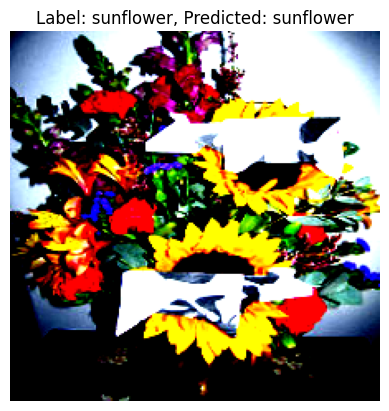

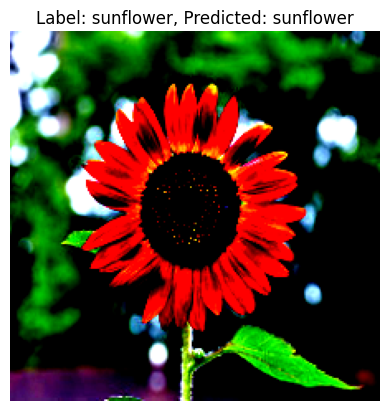

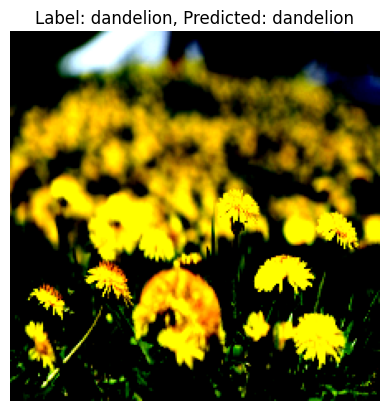

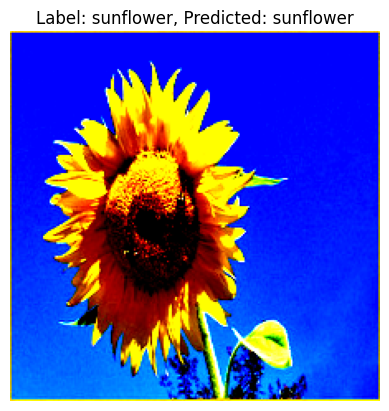

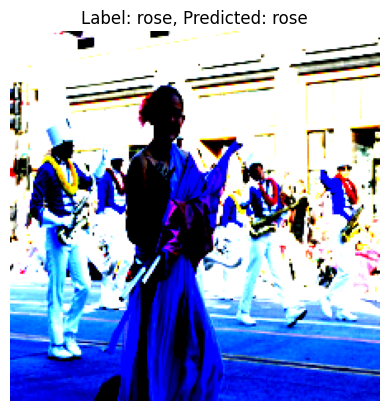

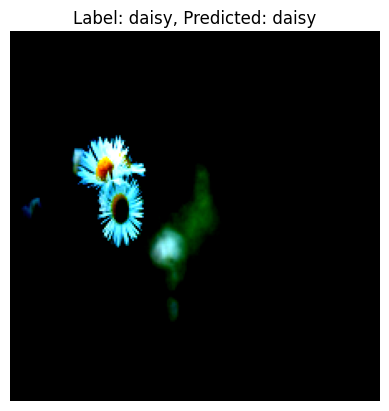

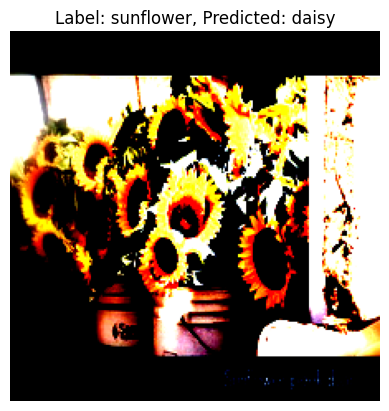

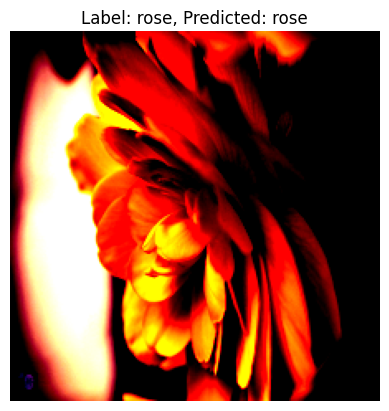

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model_pre)))
  plt.show()

По желанию, можно сохранить веса модели.

In [ ]:
#weights_fname = '/content/drive/My Drive/AAI/l3_w/lab3_weight.pth'
#torch.save(model.state_dict(), weights_fname)

2. Своя архитектура

In [ ]:
# Написать свой код здесь

model_self = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model_self.to(device) # отправляем модель на девайс (GPU)

batch_size = 20
optimizer = torch.optim.Adam(params = model_self.parameters())
lr = 0.001

loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}





Обучение

In [ ]:
loss_track_self, accuracy_track_self = trainval(model_self, loaders, optimizer, epochs=10)

100%|██████████| 166/166 [00:42<00:00,  3.95it/s]


[training] Epoch: 0.00. Loss: 1.64. Accuracy: 23.21% 


100%|██████████| 50/50 [00:06<00:00,  7.68it/s]


[validation] Epoch: 0.00. Loss: 1.58. Accuracy: 25.40% 


100%|██████████| 166/166 [00:42<00:00,  3.87it/s]


[training] Epoch: 1.00. Loss: 1.55. Accuracy: 28.96% 


100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


[validation] Epoch: 1.00. Loss: 1.42. Accuracy: 34.75% 


100%|██████████| 166/166 [00:42<00:00,  3.87it/s]


[training] Epoch: 2.00. Loss: 1.44. Accuracy: 35.09% 


100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


[validation] Epoch: 2.00. Loss: 1.34. Accuracy: 39.37% 


100%|██████████| 166/166 [00:42<00:00,  3.89it/s]


[training] Epoch: 3.00. Loss: 1.35. Accuracy: 40.44% 


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


[validation] Epoch: 3.00. Loss: 1.28. Accuracy: 42.77% 


100%|██████████| 166/166 [00:42<00:00,  3.88it/s]


[training] Epoch: 4.00. Loss: 1.27. Accuracy: 45.21% 


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


[validation] Epoch: 4.00. Loss: 1.23. Accuracy: 45.94% 


100%|██████████| 166/166 [00:42<00:00,  3.87it/s]


[training] Epoch: 5.00. Loss: 1.18. Accuracy: 50.03% 


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


[validation] Epoch: 5.00. Loss: 1.23. Accuracy: 47.87% 


100%|██████████| 166/166 [00:42<00:00,  3.88it/s]


[training] Epoch: 6.00. Loss: 1.08. Accuracy: 54.56% 


100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


[validation] Epoch: 6.00. Loss: 1.26. Accuracy: 49.34% 


100%|██████████| 166/166 [00:42<00:00,  3.89it/s]


[training] Epoch: 7.00. Loss: 0.99. Accuracy: 58.84% 


100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


[validation] Epoch: 7.00. Loss: 1.29. Accuracy: 50.27% 


100%|██████████| 166/166 [00:42<00:00,  3.89it/s]


[training] Epoch: 8.00. Loss: 0.91. Accuracy: 62.54% 


100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


[validation] Epoch: 8.00. Loss: 1.35. Accuracy: 51.04% 


100%|██████████| 166/166 [00:42<00:00,  3.89it/s]


[training] Epoch: 9.00. Loss: 0.84. Accuracy: 65.67% 


100%|██████████| 50/50 [00:06<00:00,  7.40it/s]

[validation] Epoch: 9.00. Loss: 1.55. Accuracy: 51.26% 


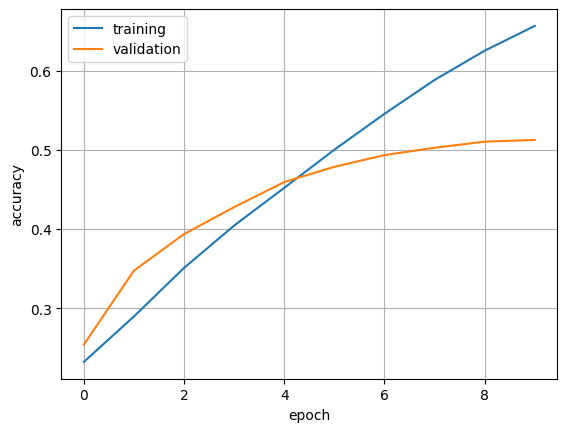

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_self['training'], label='training')
plt.plot(accuracy_track_self['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

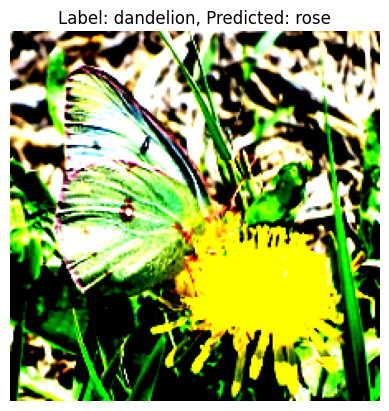

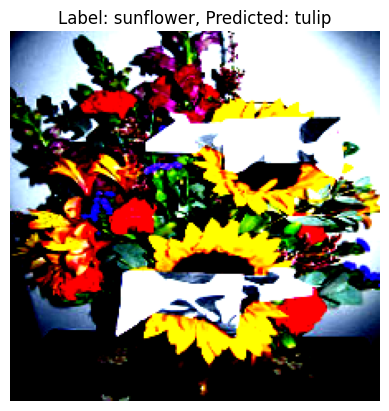

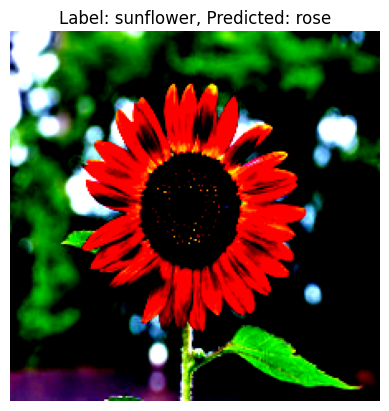

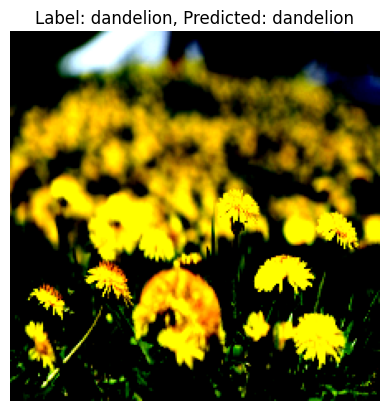

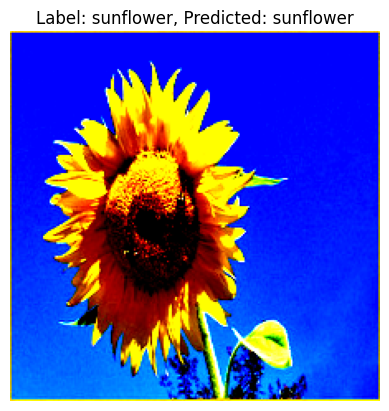

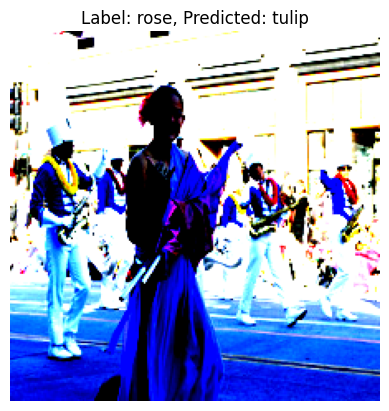

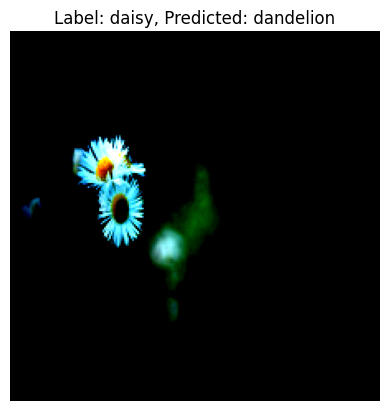

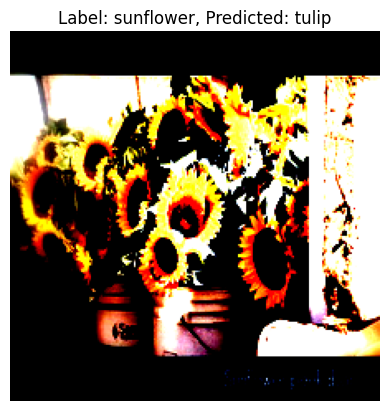

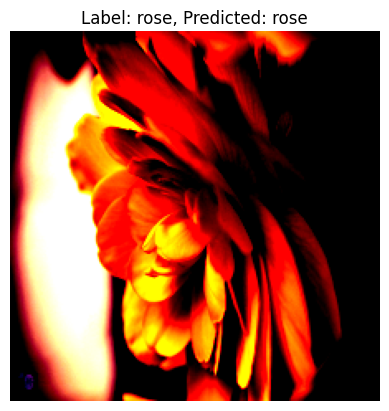

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model_self)))
  plt.show()

3. Сравнение и вузуализация 3-х архитектур

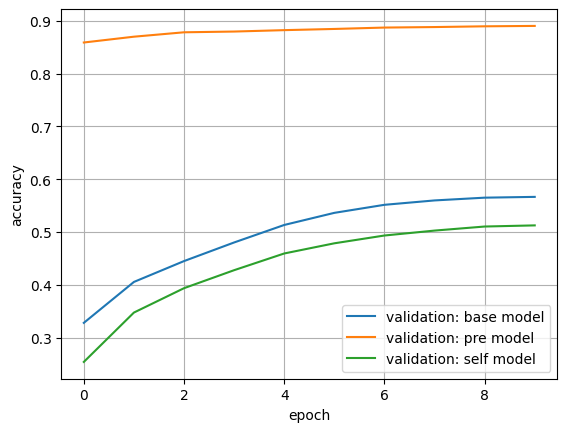

In [ ]:
# Написать свой код здесь

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(accuracy_track['validation'], label='validation: base model')
plt.plot(accuracy_track_pre['validation'], label='validation: pre model')
plt.plot(accuracy_track_self['validation'], label='validation: self model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()




# Вопросы.

## Добавьте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

ResNet-50 является сверточной нейронной сетью, которой имеет 50 слоёв глубины. Можно загрузить предварительно обученную версию сети, обученной больше чем на миллионе изображений от базы данных ImageNet. Предварительно обученная сеть может классифицировать изображения в 1 000 категорий объектов, таких как клавиатура, мышь, карандаш и многие животные. В результате сеть изучила богатые представления функции для широкого спектра изображений. Сеть имеет входной размер изображений 224 224.

## Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

***
1. Остаточные связи: Каждый остаточный блок включает два или три сверточных слоя и прямую (identity) связь, которая позволяет передавать информацию из предыдущих слоев. Это помогает избежать потери информации и улучшает обучение.

2. Слой нормализации: После каждого сверточного слоя обычно применяется пакетная нормализация, чтобы ускорить обучение и обеспечить стабильность.

3. Функция активации: Используется функция активации ReLU, что помогает в нелинейном преобразовании данных.

4. Инжектирование градиента: Благодаря остаточным связям градиенты могут "протекать" через слои, что упрощает процесс оптимизации.
***

Основные параметры ResNet-50:

- Количество слоев: 50
- Типы слоев: Сверточные слои, слой нормализации, функции активации, и объединяющие слои.
- Размер фильтров: Обычно 3x3 для сверточных слоев.
- Количество фильтров: Увеличивается с каждой группой слоев, начиная с 64 и до 2048.
- Размер входного изображения: Обычно 224x224 пикселей.
- Функция потерь: Для задачи классификации часто используется кросс-энтропийная функция потерь.
- Оптимизатор: Наиболее популярными являются Adam или SGD.

## В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

***

- Архитектура: Сверточные нейронные сети (CNN) имеют слои свертки, которые автоматически извлекают признаки из данных, в то время как полносвязные нейронные сети (FCNN) соединяют каждый нейрон на одном слое со всеми нейронами следующего слоя.

- Параметры: CNN имеют меньше параметров благодаря локальным рецептивным полям и использованию сверток, тогда как FCNN часто имеют большое количество параметров, что делает их более подверженными переобучению.

- Преобразование изображений: CNN лучше подходят для обработки изображений, так как они учитывают пространственные и временные зависимости, а FCNN могут терять эту информацию из-за своей структуры.

- Вывод и сложность: CNN могут эффективно обрабатывать многомерные данные, такие как изображения и видео, в то время как FCNN часто требуют предварительной обработки данных и могут не так эффективно работать с многомерными входами.
***

## Что такое transfer learning? Что такое предобучена нейронная сеть?

***
- Transfer learning (перенос обучения): Это метод, при котором модель, обученная на одной задаче (например, классификация изображений), адаптируется для другой, часто связанной задачи. Он позволяет сократить время и ресурсы на обучение, используя уже извлеченные признаки.

- Предобученная нейронная сеть: Это модель, которая была обучена на большом наборе данных (например, ImageNet) и теперь может быть использована в других задачах. Обычно предобученные сети служат отправной точкой, позволяя дообучить модель на меньшем наборе данных для решения специфичной задачи.
***

## Что такое функция для заморозки весов модели?

Функция для заморозки весов модели отвечает за предотвращение обновления параметров (весов) определенных слоев нейронной сети во время обучения. Это полезно, когда используются предобученные сети, и некоторые слои модели хотят оставить нетронутыми, чтобы сохранить уже обученные признаки.

Такой подход позволяет акцентировать внимание на дообучении оставшихся слоев, что может привести к повышению производительности модели относительно целевой задачи.

## Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.

## Вопросы.
Добавьте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning? Что такое предобучена нейронная сеть?

Что такое функция для заморозки весов модели?

Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.